In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import PolynomialFeatures
from urllib.request import Request, urlopen
import json
import time
from datetime import date
from pandas import Timestamp
import datetime

# scientific python add-ons
import numpy as np
import pandas as pd

from influxdb import DataFrameClient
from influxdb import InfluxDBClient

%matplotlib inline
# plotting stuff
# first line makes the plots appear in the notebook
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
    sns.set_color_codes()
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# finally, we import the pvlib library
from pvlib import solarposition,irradiance,atmosphere,pvsystem
from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR


user = 'root'
password = 'root'
dbname = 'energy'
host='192.168.56.101'
port=8086

# Temporarily avoid line protocol time conversion issues #412, #426, #431.
protocol = 'json'

#client = DataFrameClient(host, port, user, password, dbname)
client = InfluxDBClient(host, port, user, password, dbname)

# Choose a location.
# Tucson, AZ
latitude = 53.1573740
longitude =  16.6280650
pv_id = 13 
#pv_id = 189
tz = 'Europe/Warsaw'
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2
begin = '2017-01-01T00:00:00Z'
end = '2018-04-20T23:59:59Z'
#begin = '2017-08-15T00:00:00Z'
#end = '2017-08-17T23:59:59Z'
start = pd.Timestamp(begin, tz=tz) # this is kinda useless, 

In [27]:
#df = pd.read_pickle("df.pickle")
#df.head()

In [28]:
q_weather = "select * from DLWRF_surface, GUST_surface, TCDC_boundary, TCDC_convective, TCDC_entire, " \
                        "TCDC_high, TCDC_low, TCDC_middle, TMP_surface, UGRD_10, VGRD_10, ALBDO_surface " \
                        "where time > '{}' and time < '{}' "\
                        "and id = '{}' order by time".format(begin, end, pv_id)

q_pv_prod="select mean(value) AS prod_mean, sum(value) AS prod_sum from produkcja " \
                          "where time > '{}' and time < '{}' "\
                         "and id = '{}' " \
                         "GROUP BY time(3h) fill(0)".format(begin, end, pv_id)

q_pv_moc="select mean(value) AS moc_mean, sum(value) AS moc_sum from mocchwilowa  " \
                          "where time > '{}' and time < '{}' "\
                         "and id = '{}' " \
                         "GROUP BY time(3h) fill(0)".format(begin, end, pv_id)


In [29]:
raw=client.query(q_weather)

#print(raw)
features = {}
for key, data in raw.items():
    name, tags = key
    if tags is None:
        key = name
    else:
        key = (name, tuple(sorted(tags.items())))
    df = pd.DataFrame(data)
    df.time = pd.to_datetime(df.time)
    df.set_index('time', inplace=True)
    df.index = df.index.tz_localize('UTC')
    df.index = df.index.tz_convert('Europe/Warsaw')
    df.index.name = None
    features[key] = df
    
#print(features)


raw=client.query(q_pv_prod)
#print(raw)

prod = {}
for key, data in raw.items():
    name, tags = key
    if tags is None:
        key = name
    else:
        key = (name, tuple(sorted(tags.items())))
    df = pd.DataFrame(data)
    df.time = pd.to_datetime(df.time)  + datetime.timedelta(hours=3)
    df.set_index('time', inplace=True)
    df.index = df.index.tz_localize('Europe/Warsaw')
#    df.index = df.index.tz_localize('UTC')
#    df.index = df.index.tz_convert('Europe/Warsaw')
    df.index.name = None
    prod[key] = df
   


raw = client.query(q_pv_moc)
#print(raw)

moc = {}
for key, data in raw.items():
    name, tags = key
    if tags is None:
        key = name
    else:
        key = (name, tuple(sorted(tags.items())))
    df = pd.DataFrame(data)
    df.time = pd.to_datetime(df.time) + datetime.timedelta(hours=3)
    df.set_index('time', inplace=True)
    df.index = df.index.tz_localize('Europe/Warsaw')
#    df.index = df.index.tz_convert('Europe/Warsaw')
    df.index.name = None
    moc[key] = df
#print(features)

In [30]:

keys=['GUST_surface', 'ALBDO_surface', 'TCDC_boundary', 'TCDC_convective', 'TCDC_entire',
        'TCDC_high', 'TCDC_low', 'TCDC_middle', 'TMP_surface', 'UGRD_10', 'VGRD_10', 'DLWRF_surface'
    ]

df = pd.DataFrame()
df = pd.concat([features['GUST_surface']['value'],features['ALBDO_surface']['value'],  
                features['TCDC_boundary']['value'], features['TCDC_convective']['value'], features['TCDC_convective']['value'], 
                features['TCDC_high']['value'], features['TCDC_low']['value'],  
                features['TCDC_middle']['value'], features['TMP_surface']['value'], features['UGRD_10']['value'],
                features['VGRD_10']['value'], features['DLWRF_surface']['value']
                ],
               keys=keys,
               axis=1)

df = df.join(prod['produkcja'])
df = df.join(moc['mocchwilowa'])


#df[df.prod_mean <= 0.001]
df.head()

,GUST_surface,ALBDO_surface,TCDC_boundary,TCDC_convective,TCDC_entire,TCDC_high,TCDC_low,TCDC_middle,TMP_surface,UGRD_10,VGRD_10,DLWRF_surface,prod_mean,prod_sum,moc_mean,moc_sum
2017-01-01 03:00:00+01:00,3.4,0.0,0,0,0,17,0,0,299.6,0.87,-3.10,339.0,0.000000,0.000,0.000000,0.000
2017-01-01 06:00:00+01:00,1.4,6.4,0,0,0,16,0,0,299.6,-0.23,-0.97,337.0,0.000000,0.000,0.000000,0.000
2017-01-01 09:00:00+01:00,4.9,4.9,0,0,0,18,0,0,299.6,-0.43,4.13,332.0,0.001214,0.085,0.047114,3.298
2017-01-01 12:00:00+01:00,4.5,5.0,0,0,0,21,0,0,299.6,0.25,3.95,334.0,0.001662,0.113,0.067941,4.620
2017-01-01 15:00:00+01:00,1.8,7.4,0,0,0,30,0,0,299.6,-0.05,1.38,345.0,0.000838,0.062,0.033378,2.470


In [31]:
# Define forecast model
fm = GFS()
fm.set_location(start, latitude, longitude)
fm.variables = {
            'temp_air': 'TMP_surface',
            'wind_speed_gust': 'GUST_surface',
            'wind_speed_u': 'UGRD_10',
            'wind_speed_v': 'VGRD_10',
            'total_clouds': 'TCDC_entire',
            'low_clouds': 'TCDC_low',
            'mid_clouds': 'TCDC_middle',
            'high_clouds': 'TCDC_high',
            'boundary_clouds': 'TCDC_boundary',
            'convect_clouds': 'TCDC_convective',
            'ghi_raw': 'DLWRF_surface', }
forecast_data = fm.process_data(df)
forecast_data.head()

C:\Users\martinX1\Anaconda3\lib\site-packages\pvlib\irradiance.py:1152: RuntimeWarning: overflow encountered in exp
  delta_kn = a + b * np.exp(c*am)


,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds
2017-01-01 03:00:00+01:00,26.45,3.219767,0.000000,0.000000,0.000000,0,0,0,17
2017-01-01 06:00:00+01:00,26.45,0.996895,0.000000,0.000000,0.000000,0,0,0,16
2017-01-01 09:00:00+01:00,26.45,4.152325,63.854651,467.799256,25.057969,0,0,0,18
2017-01-01 12:00:00+01:00,26.45,3.957903,211.165938,696.251339,44.176350,0,0,0,21
2017-01-01 15:00:00+01:00,26.45,1.380906,57.561339,462.679689,23.531710,0,0,0,30


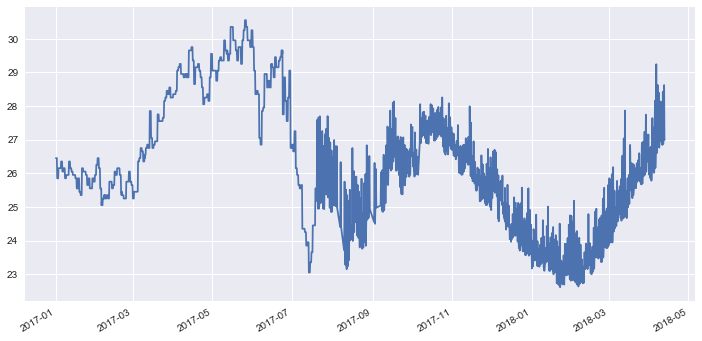

In [32]:
forecast_data['temp_air'].plot()

Text(0,0.5,'Irradiance ($W/m^{-2}$)')

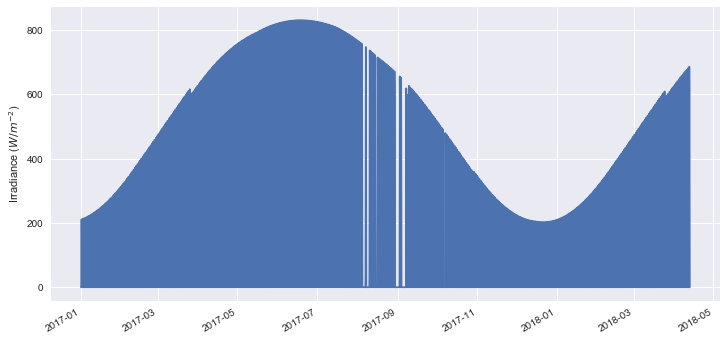

In [33]:
ghi = forecast_data['ghi']
ghi.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

In [34]:
# retrieve time and location parameters
time = forecast_data.index
a_point = fm.location
solpos = a_point.get_solarposition(time)
solpos.head(15)

,apparent_elevation,apparent_zenith,azimuth,elevation,equation_of_time,zenith
2017-01-01 03:00:00+01:00,-44.245364,134.245364,67.011251,-44.245364,-3.477348,134.245364
2017-01-01 06:00:00+01:00,-17.778687,107.778687,104.826100,-17.778687,-3.536429,107.778687
2017-01-01 09:00:00+01:00,4.923949,85.076051,139.839598,4.757259,-3.595422,85.242741
2017-01-01 12:00:00+01:00,13.943018,76.056982,180.676862,13.877154,-3.654328,76.122846
2017-01-01 15:00:00+01:00,4.399648,85.600352,221.362709,4.217856,-3.713144,85.782144
2017-01-01 18:00:00+01:00,-18.574891,108.574891,256.275387,-18.574891,-3.771870,108.574891
2017-01-01 21:00:00+01:00,-44.977164,134.977164,294.525100,-44.977164,-3.830504,134.977164
2017-01-02 03:00:00+01:00,-44.240848,134.240848,66.817862,-44.240848,-3.947493,134.240848
2017-01-02 06:00:00+01:00,-17.778712,107.778712,104.680033,-17.778712,-4.005845,107.778712
2017-01-02 09:00:00+01:00,4.957982,85.042018,139.704000,4.792191,-4.064101,85.207809


Text(0,0.5,'Airmass')

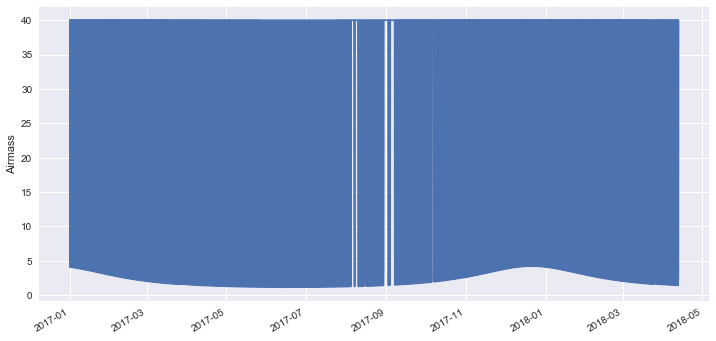

In [35]:
airmass = atmosphere.relativeairmass(solpos['apparent_zenith'])

airmass.fillna(40,inplace=True)
airmass.plot()
plt.ylabel('Airmass')

Text(0,0.5,'Extra terrestrial radiation ($W/m^{-2}$)')

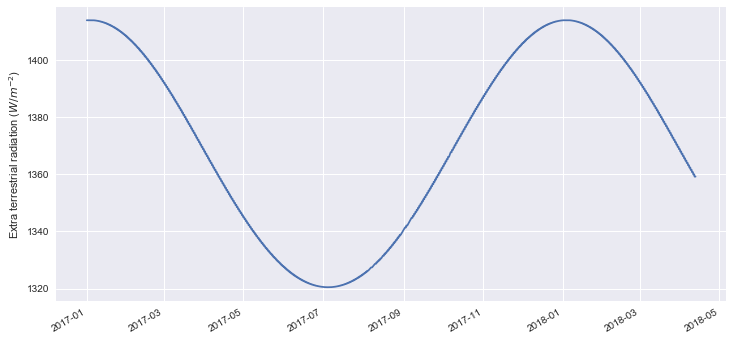

In [36]:
dni_extra = irradiance.extraradiation(forecast_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation ($W/m^{-2}$)')

Text(0,0.5,'Irradiance ($W/m^{-2}$)')

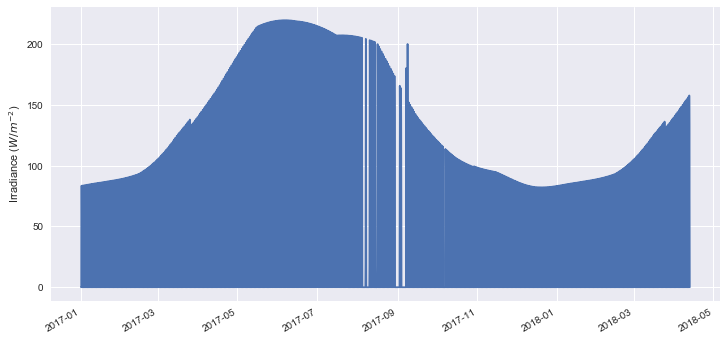

In [37]:
poa_sky_diffuse = irradiance.haydavies(surface_tilt, surface_azimuth,
                                             forecast_data['dhi'], forecast_data['dni'], dni_extra,
                                             solpos['apparent_zenith'], solpos['azimuth'])
poa_sky_diffuse.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

Text(0,0.5,'Irradiance ($W/m^{-2}$)')

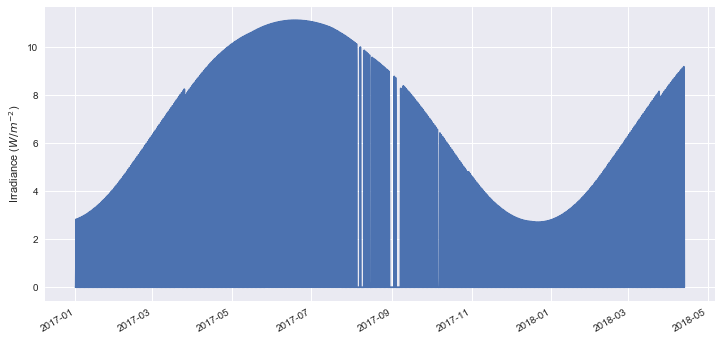

In [38]:
poa_ground_diffuse = irradiance.grounddiffuse(surface_tilt, ghi, albedo=albedo, surface_type='grass')

poa_ground_diffuse.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

Text(0,0.5,'Angle of incidence (deg)')

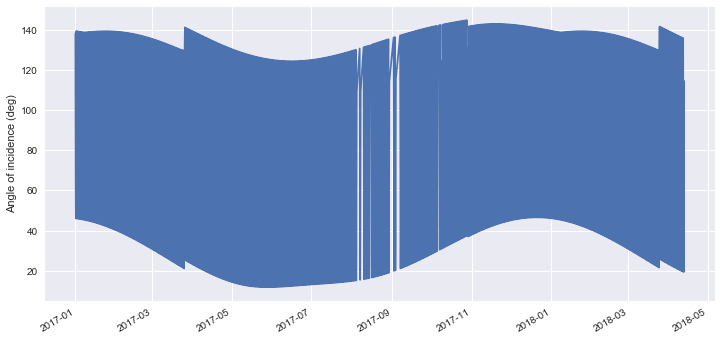

In [39]:
aoi = irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)')

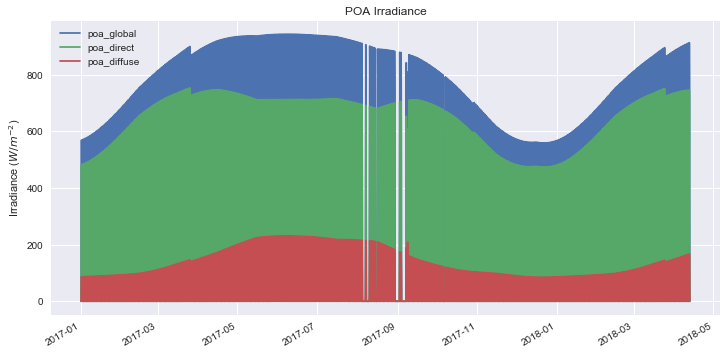

In [40]:
poa_irrad = irradiance.globalinplane(aoi, forecast_data['dni'], poa_sky_diffuse, poa_ground_diffuse)

fig = poa_irrad.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')
plt.title('POA Irradiance')
fig.plot()

#fig.get_figure().savefig("Irradiance.png")

Text(0,0.5,'Temperature (C)')

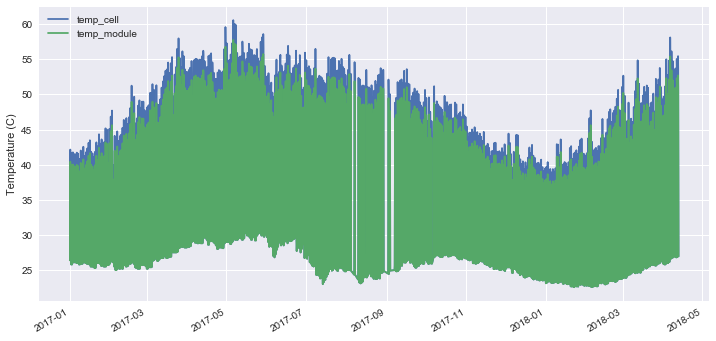

In [41]:
temperature = forecast_data['temp_air']
wnd_spd = forecast_data['wind_speed']
pvtemps = pvsystem.sapm_celltemp(poa_irrad['poa_global'], wnd_spd, temperature)

pvtemps.plot()
plt.ylabel('Temperature (C)')

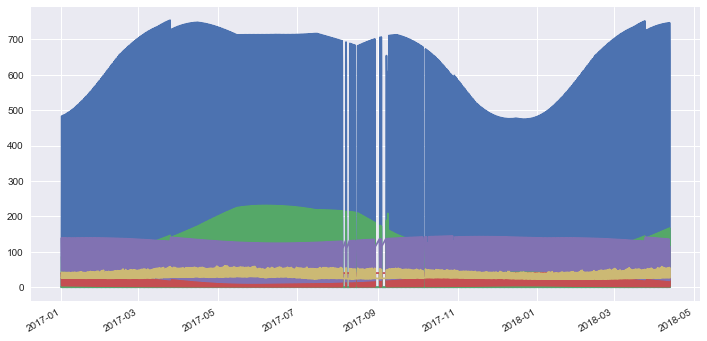

In [42]:
poa_irrad.poa_direct.plot()
poa_irrad.poa_diffuse.plot()
airmass.plot()
aoi.plot()

pvtemps['temp_cell'].plot()



#df_final['moc_mean'].plot()

In [43]:
df_final = pd.concat([poa_irrad.poa_direct,poa_irrad.poa_diffuse,airmass,aoi,pvtemps['temp_cell'],
                      df['prod_sum'],df['prod_mean'], df['moc_sum'],df['moc_mean']],
               keys=['poa_direct','poa_diffuse','airmass','aoi','temp_cell','prod_sum','prod_mean','moc_sum','moc_mean'],
               axis=1)

#df_final = df_final.loc[df_final['airmass'] <= 10]
df_final.count()
#df_final.loc[(df_final['airmass'] > 10) & (df_final['airmass'] < 40)]


poa_direct     3183
poa_diffuse    3183
airmass        3183
aoi            3183
temp_cell      3183
prod_sum       3183
prod_mean      3183
moc_sum        3183
moc_mean       3183
dtype: int64

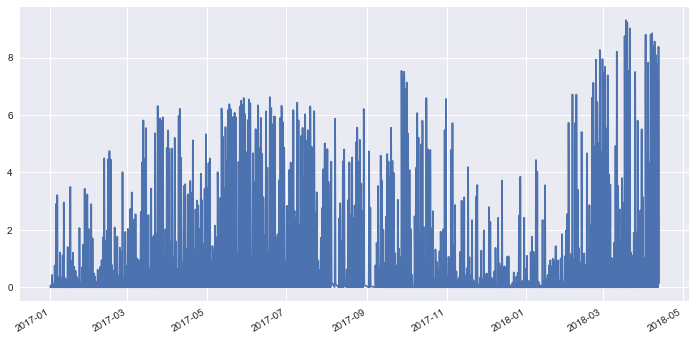

In [44]:
#df_final['airmass'].plot()
df_final['moc_mean'].plot()

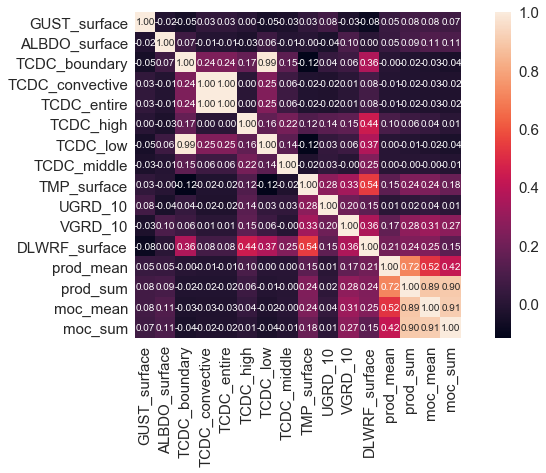

In [45]:
cm = np.corrcoef(df.values.T)
cm
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws = {'size': 10},
        yticklabels=df.columns, xticklabels=df.columns)
plt.show()

In [46]:
#df_b = df_final
df_final = df_b.loc[(df_b['prod_sum'] <= 30)]

cm = np.corrcoef(df_final.values.T)
cm
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws = {'size': 10},
        yticklabels=df_final.columns, xticklabels=df_final.columns)
plt.show()

NameError: name 'df_b' is not defined

In [ ]:
plt.scatter(df_final['prod_sum'], df_final['poa_direct'])
plt.xlabel('prod_sum')
plt.ylabel('poa_direct')
plt.show()

plt.scatter(df_final['prod_sum'], df_final['poa_diffuse'])
plt.xlabel('prod_sum')
plt.ylabel('poa_diffuse')
plt.show()

plt.scatter(df_final['prod_sum'], df_final['airmass'])
plt.xlabel('prod_sum')
plt.ylabel('airmass')
plt.show()

plt.scatter(df_final['prod_sum'], df_final['aoi'])
plt.xlabel('prod_sum')
plt.ylabel('aoi')
plt.show()

plt.scatter(df_final['prod_sum'], df_final['temp_cell'])
plt.xlabel('prod_sum')
plt.ylabel('temp_cell')
plt.show()

In [ ]:
#df.to_pickle("df.pickle") 
#df_final.to_pickle("df_final.pickle") 